In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 10.1 MB/s 
     |████████████████████████████████| 62 kB 347 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import yfinance as yahoo_finance
import pandas as pd
import statsmodels.api as sm
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Getting Walmart One Year Data in a dataframe from yahoo finance api

In [15]:
walmart_data = yahoo_finance.Ticker("WMT")
walmart_df = walmart_data.history(period="5y")
walmart_df = walmart_df.reset_index(level = 0)
walmart_df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

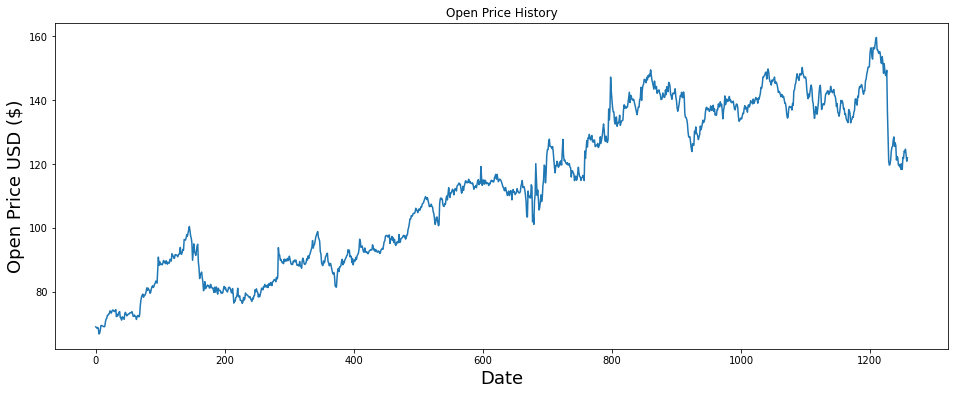

In [16]:
plt.figure(figsize=(16,6))
plt.title('Open Price History')
plt.plot(walmart_df.Open)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

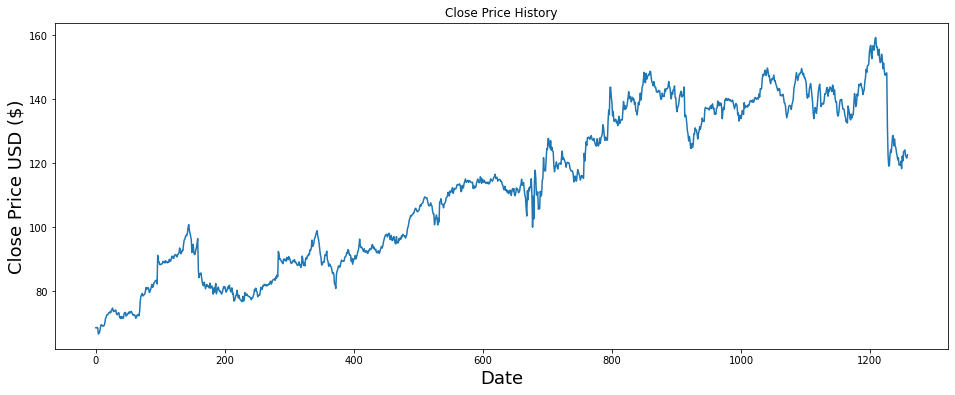

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(walmart_df.Close)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## Getting S&P500 One Year Data in a dataframe from yahoo finance api

In [4]:
sp_data = yahoo_finance.Ticker("^GSPC")
sp_df = sp_data.history(period="5y")
sp_df = sp_df.reset_index(level = 0)
sp_df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

In [5]:
sp_df

,Date,Open,High,Low,Close,Volume
0,2017-07-03,2431.389893,2439.169922,2428.689941,2429.010010,1962290000
1,2017-07-05,2430.780029,2434.899902,2422.050049,2432.540039,3367220000
2,2017-07-06,2423.439941,2424.280029,2407.699951,2409.750000,3364520000
3,2017-07-07,2413.520020,2426.919922,2413.520020,2425.179932,2901330000
4,2017-07-10,2424.510010,2432.000000,2422.270020,2427.429932,2999130000
...,...,...,...,...,...,...
1254,2022-06-27,3920.760010,3927.719971,3889.659912,3900.110107,3385120000
1255,2022-06-28,3913.000000,3945.860107,3820.139893,3821.550049,3590980000
1256,2022-06-29,3825.090088,3836.500000,3799.020020,3818.830078,3458850000
1257,2022-06-30,3785.989990,3818.989990,3738.669922,3785.379883,4032260000


## Calculating the Beta for our CAPM model between Walmart and S&P500

In [6]:
capm_df = pd.concat([walmart_df['Close'], sp_df['Close']], axis = 1)
capm_df = capm_df.join(walmart_df['Date'])
capm_df.columns = ['Walmart', 'S&P500', 'Date']
capm_df.set_index('Date', inplace=True)

daily_returns = capm_df.pct_change(1)
daily_returns = daily_returns.iloc[1:, :]

In [7]:
daily_returns.head(5)

,Walmart,S&P500
Date,,
2017-07-05,-0.000531,0.001453
2017-07-06,0.001992,-0.009369
2017-07-07,-0.001855,0.006403
2017-07-10,-0.027877,0.000928
2017-07-11,0.003277,-0.000783


In [8]:
daily_returns.mean()

Walmart    0.000565
S&P500     0.000444
dtype: float64

In [9]:
beta, alpha = np.polyfit(daily_returns['S&P500'], daily_returns['Walmart'], 1)
print('Beta for {} stock is = {} and alpha is = {}'.format('Walmart', round(beta,3), round(alpha,3)))  

Beta for Walmart stock is = 0.506 and alpha is = 0.0


In [10]:

rm = round(daily_returns['S&P500'].mean() * 252 * 5,3)
print(beta, rm)

0.5059374779323399 0.559


## Calculating the CAPM

In [11]:
rf = 5 ## average value from sources on google

capm_walmart = round(rf + ( beta * (rm-rf) ) ,3)
capm_walmart

2.753

## Now that we have percentage change, we can proceed with a regression model out of this

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
x = daily_returns.iloc[:, 1].values ## s&p500 data
y = daily_returns.iloc[:, 0].values ## walmart data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.45, random_state = 42)

In [14]:
x_train= x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(691, 1) (691,)
(567, 1) (567,)


In [15]:
sl_reg = LinearRegression()
sl_reg.fit(x_train, y_train)

LinearRegression()

In [16]:
y_pred = sl_reg.predict(x_test)

## Visualizing the results

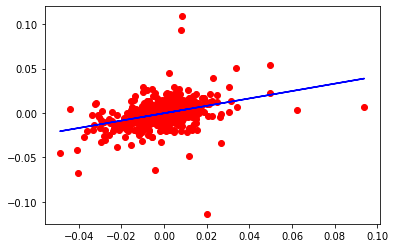

In [17]:
# Visualising the Train set results
plt.scatter(x_train, y_train, color='red')
plt.plot(x_train, sl_reg.predict(x_train), color='blue')
plt.show()

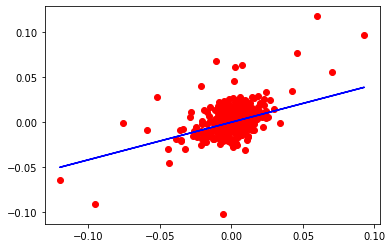

In [18]:
# Visualising the Test set results
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, y_pred, color='blue')
plt.show()

## Using Statsmodel summary to get performance of our regressor

In [19]:
x1 = sm.add_constant(x)
ols_summary_model = sm.OLS(y, x1)

# fit model and print results
inference = ols_summary_model.fit()
inference.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     325.9
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           5.87e-65
Time:                        19:22:43   Log-Likelihood:                 3683.7
No. Observations:                1258   AIC:                            -7363.
Df Residuals:                    1256   BIC:                            -7353.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.930      0.352      -0.000       0.001
x1             0.5059      0.028     18.054      0.000       0.451       0.561
==============================================================================
Omnibus:                      315.255   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17312.329
Skew:                           0.149   Prob(JB):                         0.00
Kurtosis:                      21.171   Cond. No.                         76.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Using GARCH for Price Prediction

In [4]:
walmart_returns = 100 * walmart_df.Close.pct_change().dropna()

NameError: ignored

In [5]:
plt.figure(figsize=(10,4))
plt.plot(walmart_returns)
plt.ylabel('Percent Change', fontsize=16)
plt.title('Walmart Returns', fontsize=20)

NameError: ignored

In [ ]:
! pip install arch

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
## partial autocorrelation function

plot_pacf(walmart_returns)
plt.plot()

In [ ]:
model = arch_model(walmart_returns, p=3, q=3)
model_fit = model.fit()
model_fit.summary()

In [ ]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = walmart_returns[:-(test_size-i)]
    model = arch_model(train, p=3, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index = walmart_returns.index[-365:])

In [ ]:
plt.figure(figsize=(10,4))
true, = plt.plot(walmart_returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

### We can see that the GARCH model is not bursty because it takes into consideration the variance in present day values as well as the lag's. Which is no the case with ARCH model.

In [ ]:
model = arch_model(walmart_returns, p=3, q=0)
model_fit = model.fit()
model_fit.summary()

In [ ]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = walmart_returns[:-(test_size-i)]
    model = arch_model(train, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [ ]:
rolling_predictions = pd.Series(rolling_predictions, index = walmart_returns.index[-365:])

In [ ]:
plt.figure(figsize=(10,4))
true, = plt.plot(walmart_returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

In [ ]:
walmart_df = walmart_df.reset_index()['close']

In [ ]:
walmart_df.Date = walmart_df.Date.astype('datetime64[D]')

In [ ]:
new_df = walmart_df.filter(['Close'])
dataset = new_df.values
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

In [ ]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

In [ ]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
train = walmart_df[:training_data_len]
valid = walmart_df[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Generating Trading Signals Using Bollinger Bands

In [ ]:
walmart_df['TypicalPrice'] = (walmart_df['Close'] + walmart_df['Low'] + walmart_df['High'])/3
walmart_df['std'] = walmart_df['TypicalPrice'].rolling(20).std(ddof=0)
walmart_df['Moving_Avg_Typ_Price'] = walmart_df['TypicalPrice'].rolling(20).mean()
walmart_df['Band_Upper'] = walmart_df['Moving_Avg_Typ_Price'] + 2*walmart_df['std']
walmart_df['Band_Lower'] = walmart_df['Moving_Avg_Typ_Price'] - 2*walmart_df['std']
walmart_df

In [ ]:
import datetime as dt

#ticker = pdr.get_data_yahoo("WMT", dt.datetime(2020, 1, 1), dt.datetime.now())[['Close', 'High', 'Low']]
# Boillinger band calculations

walmart_price_bands = walmart_df.dropna()


ax = walmart_price_bands[['Close', 'Band_Upper', 'Band_Lower']].plot(color=['blue', 'orange', 'yellow'], figsize = (30,15))

ax.fill_between(walmart_price_bands.index, walmart_price_bands['Band_Lower'], walmart_price_bands['Band_Upper'], facecolor='orange', alpha=0.1)
plt.show()

In [22]:


# import package
import pandas_datareader.data as web
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime



In [26]:
start = datetime.datetime(2017, 6, 30) 
end = datetime.datetime(2022, 6, 30) 
# extract the closing price data
wmt_df = yahoo_finance.download('WMT',start ,end)
wmt_df.drop(wmt_df.columns.difference(['Close']), 1, inplace=True)
wmt_df.head(10)

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


,Close
Date,
2017-06-30,75.680000
2017-07-03,75.360001
2017-07-05,75.320000
2017-07-06,75.470001
2017-07-07,75.330002
2017-07-10,73.230003
2017-07-11,73.470001
2017-07-12,73.940002
2017-07-13,75.050003


In [28]:
# create 20 days simple moving average column
wmt_df['20_SMA'] = wmt_df['Close'].rolling(window = 20, min_periods = 1).mean()
# create 50 days simple moving average column
wmt_df['50_SMA'] = wmt_df['Close'].rolling(window = 50, min_periods = 1).mean()
# display first few rows
wmt_df.head()


,Close,20_SMA,50_SMA
Date,,,
2017-06-30,75.680000,75.680000,75.680000
2017-07-03,75.360001,75.520000,75.520000
2017-07-05,75.320000,75.453334,75.453334
2017-07-06,75.470001,75.457500,75.457500
2017-07-07,75.330002,75.432001,75.432001


In [29]:


wmt_df['Signal'] = 0.0
wmt_df['Signal'] = np.where(wmt_df['20_SMA'] > wmt_df['50_SMA'], 1.0, 0.0)



In [30]:
wmt_df['Position'] = wmt_df['Signal'].diff()
# display first few rows
wmt_df.head()

,Close,20_SMA,50_SMA,Signal,Position
Date,,,,,
2017-06-30,75.680000,75.680000,75.680000,0.0,NaN
2017-07-03,75.360001,75.520000,75.520000,0.0,0.0
2017-07-05,75.320000,75.453334,75.453334,0.0,0.0
2017-07-06,75.470001,75.457500,75.457500,0.0,0.0
2017-07-07,75.330002,75.432001,75.432001,0.0,0.0


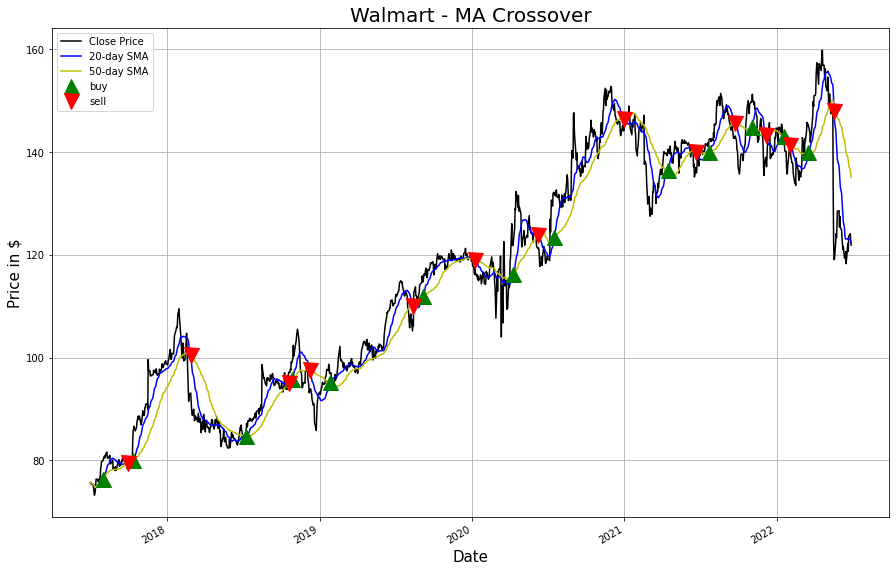

In [31]:
plt.figure(figsize = (15,10))
# plot close price, short-term and long-term moving averages 
wmt_df['Close'].plot(color = 'k', label= 'Close Price') 
wmt_df['20_SMA'].plot(color = 'b',label = '20-day SMA') 
wmt_df['50_SMA'].plot(color = 'y',label = '50-day SMA')
# plot ‘buy’ signals
plt.plot(wmt_df[wmt_df['Position'] == 1].index, 
         wmt_df['20_SMA'][wmt_df['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(wmt_df[wmt_df['Position'] == -1].index, 
         wmt_df['20_SMA'][wmt_df['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price in $', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Walmart - MA Crossover', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [32]:
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

In [34]:
days_out = 30

# create a new column signal_flag to calculate the diff. Then use Numpy to define the sign.
walmart_df['Signal_Flag'] = walmart_df['Close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 10 rows
walmart_df.head(10)

,Date,Open,High,Low,Close,Volume,Signal_Flag
0,2017-07-03,68.976757,69.431509,68.285539,68.540199,4848600,NaN
1,2017-07-05,68.713011,69.076807,68.367395,68.503822,6036900,NaN
2,2017-07-06,68.531093,69.094988,68.431047,68.640236,6161800,NaN
3,2017-07-07,68.803950,68.958564,68.258249,68.512909,5307100,NaN
4,2017-07-10,68.349212,68.494729,66.512010,66.602966,15066700,NaN
5,2017-07-11,66.739392,67.348765,66.693921,66.821251,7532600,NaN
6,2017-07-12,66.994035,67.494258,66.994035,67.248695,5700200,NaN
7,2017-07-13,67.912624,68.440138,67.767107,68.258240,8160500,NaN
8,2017-07-14,69.367854,69.631611,69.040439,69.431519,9151900,NaN
9,2017-07-17,69.386032,69.913545,69.295083,69.458794,8835600,NaN


In [36]:


walmart_df.sort_values(by = ['Date'], inplace = True)

# calculate the change in price
walmart_df['change_in_price'] = walmart_df['Close'].diff()


In [37]:
n = 14

# First make a copy of the dataframe column twice
up_df, down_df = walmart_df[['change_in_price']].copy(), walmart_df[['change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
walmart_df['down_days'] = down_df['change_in_price']
walmart_df['up_days'] = up_df['change_in_price']
walmart_df['RSI'] = relative_strength_index

# Display the head.
walmart_df.head(10)

,Date,Open,High,Low,Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI
0,2017-07-03,68.976757,69.431509,68.285539,68.540199,4848600,NaN,NaN,NaN,NaN,NaN
1,2017-07-05,68.713011,69.076807,68.367395,68.503822,6036900,NaN,-0.036377,0.036377,0.000000,0.000000
2,2017-07-06,68.531093,69.094988,68.431047,68.640236,6161800,NaN,0.136414,0.000000,0.136414,81.227437
3,2017-07-07,68.803950,68.958564,68.258249,68.512909,5307100,NaN,-0.127327,0.127327,0.000000,43.325703
4,2017-07-10,68.349212,68.494729,66.512010,66.602966,15066700,NaN,-1.909943,1.909943,0.000000,4.773579
5,2017-07-11,66.739392,67.348765,66.693921,66.821251,7532600,NaN,0.218285,0.000000,0.218285,14.774149
6,2017-07-12,66.994035,67.494258,66.994035,67.248695,5700200,NaN,0.427444,0.000000,0.427444,31.118703
7,2017-07-13,67.912624,68.440138,67.767107,68.258240,8160500,NaN,1.009544,0.000000,1.009544,54.761668
8,2017-07-14,69.367854,69.631611,69.040439,69.431519,9151900,NaN,1.173279,0.000000,1.173279,69.020833
9,2017-07-17,69.386032,69.913545,69.295083,69.458794,8835600,NaN,0.027275,0.000000,0.027275,69.280558


In [38]:
n = 14

# Make a copy of the high and low column.
low_14, high_14 = walmart_df[['Low']].copy(), walmart_df[['High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((walmart_df['Close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
walmart_df['low_14'] = low_14
walmart_df['high_14'] = high_14
walmart_df['k_percent'] = k_percent

# Display the head.
walmart_df.head(10)

,Date,Open,High,Low,Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
0,2017-07-03,68.976757,69.431509,68.285539,68.540199,4848600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-07-05,68.713011,69.076807,68.367395,68.503822,6036900,NaN,-0.036377,0.036377,0.000000,0.000000,NaN,NaN,NaN
2,2017-07-06,68.531093,69.094988,68.431047,68.640236,6161800,NaN,0.136414,0.000000,0.136414,81.227437,NaN,NaN,NaN
3,2017-07-07,68.803950,68.958564,68.258249,68.512909,5307100,NaN,-0.127327,0.127327,0.000000,43.325703,NaN,NaN,NaN
4,2017-07-10,68.349212,68.494729,66.512010,66.602966,15066700,NaN,-1.909943,1.909943,0.000000,4.773579,NaN,NaN,NaN
5,2017-07-11,66.739392,67.348765,66.693921,66.821251,7532600,NaN,0.218285,0.000000,0.218285,14.774149,NaN,NaN,NaN
6,2017-07-12,66.994035,67.494258,66.994035,67.248695,5700200,NaN,0.427444,0.000000,0.427444,31.118703,NaN,NaN,NaN
7,2017-07-13,67.912624,68.440138,67.767107,68.258240,8160500,NaN,1.009544,0.000000,1.009544,54.761668,NaN,NaN,NaN
8,2017-07-14,69.367854,69.631611,69.040439,69.431519,9151900,NaN,1.173279,0.000000,1.173279,69.020833,NaN,NaN,NaN
9,2017-07-17,69.386032,69.913545,69.295083,69.458794,8835600,NaN,0.027275,0.000000,0.027275,69.280558,NaN,NaN,NaN


In [39]:
n = 14

# Make a copy of the high and low column.
low_14, high_14 = walmart_df[['Low']].copy(), walmart_df[['High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - walmart_df['Close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
walmart_df['r_percent'] = r_percent

# Display the head.
walmart_df.head(10)

,Date,Open,High,Low,Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,2017-07-03,68.976757,69.431509,68.285539,68.540199,4848600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-07-05,68.713011,69.076807,68.367395,68.503822,6036900,NaN,-0.036377,0.036377,0.000000,0.000000,NaN,NaN,NaN,NaN
2,2017-07-06,68.531093,69.094988,68.431047,68.640236,6161800,NaN,0.136414,0.000000,0.136414,81.227437,NaN,NaN,NaN,NaN
3,2017-07-07,68.803950,68.958564,68.258249,68.512909,5307100,NaN,-0.127327,0.127327,0.000000,43.325703,NaN,NaN,NaN,NaN
4,2017-07-10,68.349212,68.494729,66.512010,66.602966,15066700,NaN,-1.909943,1.909943,0.000000,4.773579,NaN,NaN,NaN,NaN
5,2017-07-11,66.739392,67.348765,66.693921,66.821251,7532600,NaN,0.218285,0.000000,0.218285,14.774149,NaN,NaN,NaN,NaN
6,2017-07-12,66.994035,67.494258,66.994035,67.248695,5700200,NaN,0.427444,0.000000,0.427444,31.118703,NaN,NaN,NaN,NaN
7,2017-07-13,67.912624,68.440138,67.767107,68.258240,8160500,NaN,1.009544,0.000000,1.009544,54.761668,NaN,NaN,NaN,NaN
8,2017-07-14,69.367854,69.631611,69.040439,69.431519,9151900,NaN,1.173279,0.000000,1.173279,69.020833,NaN,NaN,NaN,NaN
9,2017-07-17,69.386032,69.913545,69.295083,69.458794,8835600,NaN,0.027275,0.000000,0.027275,69.280558,NaN,NaN,NaN,NaN


In [40]:
# Calculate the MACD
ema_26 = walmart_df['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = walmart_df['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
walmart_df['MACD'] = macd
walmart_df['MACD_EMA'] = ema_9_macd

# Print the head.
walmart_df.head(10)

,Date,Open,High,Low,Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,2017-07-03,68.976757,69.431509,68.285539,68.540199,4848600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2017-07-05,68.713011,69.076807,68.367395,68.503822,6036900,NaN,-0.036377,0.036377,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000816,-0.000453
2,2017-07-06,68.531093,69.094988,68.431047,68.640236,6161800,NaN,0.136414,0.000000,0.136414,81.227437,NaN,NaN,NaN,NaN,0.003190,0.001040
3,2017-07-07,68.803950,68.958564,68.258249,68.512909,5307100,NaN,-0.127327,0.127327,0.000000,43.325703,NaN,NaN,NaN,NaN,0.000337,0.000802
4,2017-07-10,68.349212,68.494729,66.512010,66.602966,15066700,NaN,-1.909943,1.909943,0.000000,4.773579,NaN,NaN,NaN,NaN,-0.077221,-0.022408
5,2017-07-11,66.739392,67.348765,66.693921,66.821251,7532600,NaN,0.218285,0.000000,0.218285,14.774149,NaN,NaN,NaN,NaN,-0.113059,-0.046980
6,2017-07-12,66.994035,67.494258,66.994035,67.248695,5700200,NaN,0.427444,0.000000,0.427444,31.118703,NaN,NaN,NaN,NaN,-0.114731,-0.064126
7,2017-07-13,67.912624,68.440138,67.767107,68.258240,8160500,NaN,1.009544,0.000000,1.009544,54.761668,NaN,NaN,NaN,NaN,-0.065993,-0.064574
8,2017-07-14,69.367854,69.631611,69.040439,69.431519,9151900,NaN,1.173279,0.000000,1.173279,69.020833,NaN,NaN,NaN,NaN,0.026971,-0.043427
9,2017-07-17,69.386032,69.913545,69.295083,69.458794,8835600,NaN,0.027275,0.000000,0.027275,69.280558,NaN,NaN,NaN,NaN,0.093931,-0.012651


In [41]:
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
walmart_df['Price_Rate_Of_Change'] = walmart_df['Close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 5 rows
walmart_df.head(5)

,Date,Open,High,Low,Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,2017-07-03,68.976757,69.431509,68.285539,68.540199,4848600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,2017-07-05,68.713011,69.076807,68.367395,68.503822,6036900,NaN,-0.036377,0.036377,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000816,-0.000453,NaN
2,2017-07-06,68.531093,69.094988,68.431047,68.640236,6161800,NaN,0.136414,0.000000,0.136414,81.227437,NaN,NaN,NaN,NaN,0.003190,0.001040,NaN
3,2017-07-07,68.803950,68.958564,68.258249,68.512909,5307100,NaN,-0.127327,0.127327,0.000000,43.325703,NaN,NaN,NaN,NaN,0.000337,0.000802,NaN
4,2017-07-10,68.349212,68.494729,66.512010,66.602966,15066700,NaN,-1.909943,1.909943,0.000000,4.773579,NaN,NaN,NaN,NaN,-0.077221,-0.022408,NaN


In [42]:
def obv(group):

    # Grab the volume and close column.
    volume = walmart_df['Volume']
    change = walmart_df['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    #returning panda series
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = walmart_df.apply(obv)


# display the data frame.
walmart_df.head(5)

,Date,Open,High,Low,Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,2017-07-03,68.976757,69.431509,68.285539,68.540199,4848600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,2017-07-05,68.713011,69.076807,68.367395,68.503822,6036900,NaN,-0.036377,0.036377,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000816,-0.000453,NaN
2,2017-07-06,68.531093,69.094988,68.431047,68.640236,6161800,NaN,0.136414,0.000000,0.136414,81.227437,NaN,NaN,NaN,NaN,0.003190,0.001040,NaN
3,2017-07-07,68.803950,68.958564,68.258249,68.512909,5307100,NaN,-0.127327,0.127327,0.000000,43.325703,NaN,NaN,NaN,NaN,0.000337,0.000802,NaN
4,2017-07-10,68.349212,68.494729,66.512010,66.602966,15066700,NaN,-1.909943,1.909943,0.000000,4.773579,NaN,NaN,NaN,NaN,-0.077221,-0.022408,NaN


In [43]:
# Grab the `Close` column.
close_groups = walmart_df['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
walmart_df['Prediction'] = close_groups

# To keep the prediction column as a binary classifier will change flat days and consider them up days.
walmart_df.loc[walmart_df['Prediction'] == 0.0] = 1.0

# print the head
walmart_df.head(5)

,Date,Open,High,Low,Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
0,2017-07-03 00:00:00,68.976757,69.431509,68.285539,68.540199,4848600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
1,2017-07-05 00:00:00,68.713011,69.076807,68.367395,68.503822,6036900,NaN,-0.036377,0.036377,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.000816,-0.000453,NaN,-1.0
2,2017-07-06 00:00:00,68.531093,69.094988,68.431047,68.640236,6161800,NaN,0.136414,0.000000,0.136414,81.227437,NaN,NaN,NaN,NaN,0.003190,0.001040,NaN,1.0
3,2017-07-07 00:00:00,68.803950,68.958564,68.258249,68.512909,5307100,NaN,-0.127327,0.127327,0.000000,43.325703,NaN,NaN,NaN,NaN,0.000337,0.000802,NaN,-1.0
4,2017-07-10 00:00:00,68.349212,68.494729,66.512010,66.602966,15066700,NaN,-1.909943,1.909943,0.000000,4.773579,NaN,NaN,NaN,NaN,-0.077221,-0.022408,NaN,-1.0


In [49]:
walmart = walmart_df.dropna()



# Print the head.
walmart

,Date,Open,High,Low,Close,Volume,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
30,2017-08-15 00:00:00,73.977594,74.499272,73.712178,73.922676,7066100,1.0,0.064079,0.000000,0.064079,65.661970,71.377853,75.039250,69.504156,-30.495844,0.934727,0.939908,0.009289,1.0
31,2017-08-16 00:00:00,74.380292,74.535886,73.712182,74.114883,11536000,1.0,0.192207,0.000000,0.192207,68.202605,72.341908,75.039250,65.730461,-34.269539,0.912107,0.934344,0.007659,1.0
32,2017-08-17 00:00:00,72.165458,73.044073,71.689544,72.943398,17293700,1.0,-1.171486,1.171486,0.000000,44.860286,71.689544,75.039250,37.431742,-62.568258,0.797141,0.906886,-0.003463,-1.0
33,2017-08-18 00:00:00,72.870158,73.538267,72.558978,72.586433,9753000,1.0,-0.356964,0.356964,0.000000,40.041984,71.689544,75.039250,26.775161,-73.224839,0.671477,0.859780,-0.018100,-1.0
34,2017-08-21 00:00:00,72.412566,73.282027,72.110540,72.952545,9613900,1.0,0.366112,0.000000,0.366112,46.803610,71.689544,75.039250,37.704830,-62.295170,0.592864,0.806375,-0.016897,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2022-06-27 00:00:00,123.779999,124.739998,122.790001,124.120003,6629700,-1.0,0.400002,0.000000,0.400002,56.728112,117.900002,125.309998,83.940682,-16.059318,-3.279987,-4.527343,0.039444,1.0
1255,2022-06-28 00:00:00,124.660004,125.570000,122.290001,122.370003,5133000,-1.0,-1.750000,1.750000,0.000000,48.084876,117.900002,125.570000,58.279039,-41.720961,-3.050863,-4.232047,0.024360,-1.0
1256,2022-06-29 00:00:00,122.889999,123.349998,120.970001,121.919998,6370500,-1.0,-0.450005,0.450005,0.000000,46.005127,117.900002,125.570000,52.411964,-47.588036,-2.872479,-3.960133,0.021277,-1.0
1257,2022-06-30 00:00:00,120.879997,122.059998,119.889999,121.580002,6388700,-1.0,-0.339996,0.339996,0.000000,44.333498,117.900002,125.570000,47.979155,-52.020845,-2.727107,-3.713528,0.007959,-1.0


In [50]:
walmart.RSI.mean()

53.24575355231409

In [51]:
walmart.MACD.mean()

0.3137601633789753

<Figure size 216x288 with 0 Axes>

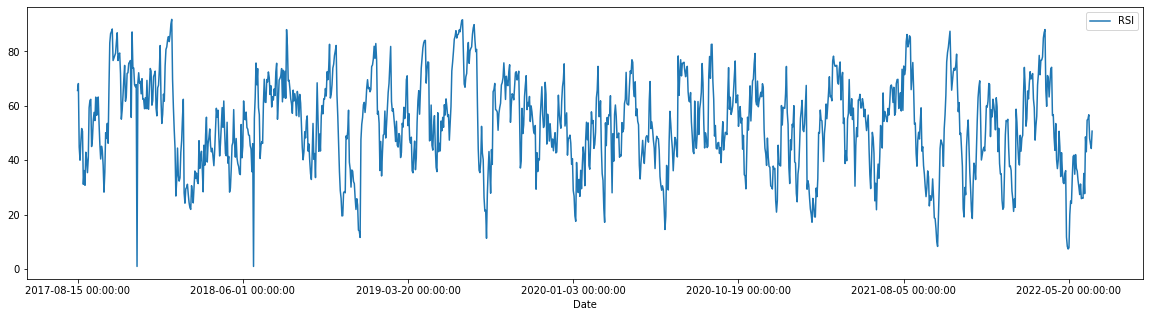

In [58]:
plt.figure(figsize=(3,4))
walmart.plot(x='Date', y='RSI', figsize = (20, 5))

In [45]:
# Splitting data into x and y columns
X_Cols = walmart[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD']]
Y_Cols = walmart['Prediction']

# Splitting it further into train and test values
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Creating a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [46]:
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  67.53246753246754


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


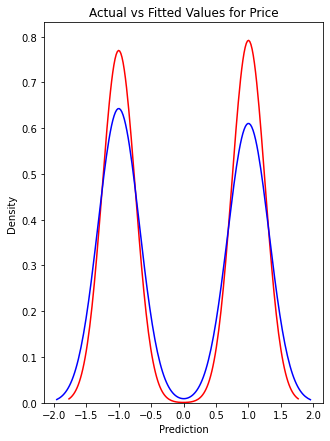

In [48]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values for Price')


plt.show()
plt.close()